Electronic Health Records
=========================



## Introduction



In this second activity, you will work on all the concepts that we have been **practicing over the last weeks**. You will practice:

1.  SQL (5 points)
2.  Regular expressions (2 points)
3.  Bringing everything together (3 points)

Some of the exercises on each of the blocks have **a common factor**, the study of [**heart failure**](https://www.cdc.gov/heartdisease/heart_failure.htm), a disease that affects the efficiency of the heart pumping blood and oxygen to other organs. This disease has a large prevalence in the US and it&rsquo;s associated with a 13% of the deaths across the country.

Some notes:

-   The **deadline** is set for Friday, **January 6th at 23:59 CET**. No extensions will be allowed. Any **late submission** will be evaluated with a cap on the **maximum grade of 6**.
-   As you know, there are many ways to do a task. Here, **besides correctness, we will also evaluate efficiency**; if your query takes more than a minute, consider that there is something that you need to change.
-   You need to work on **teams of two**. The team may be different to the one for the first assignment, you need to create it again.
-   In the **Software** section in Moodle you will find the details to create a Docker container that includes the drivers to connect to MIMIC-III database. You should run and fill this notebook within that container.
-   You can find the information regarding the database structure on the [**MIMIC-III webpage**](https://mimic.mit.edu/docs/iii/).
-   Just **one member of the team needs to submit the notebook** to the Moodle task. **The format of the delivery is `A2-assignment-groupID`**, using the group id assigned on Moodle.
-   You can use **any function available for [MariaDB](https://mariadb.com/kb/en/built-in-functions/)** to perform any of the requested queries. It is your job, using the available documentation, to find the one that better fits the job to do.
-   The R packages that you will need to use are defined at the beginning of the document. **YOU CANNOT ALTER OR USE ADDITIONAL PACKAGES NOT LISTED THERE**.
-   For complex codes (more than a few lines), you must use **comments to explain your design decisions**.
-   **Variable naming is an important part of programming**. Use meaningful names in order to increase readability.
-   **Do not get stuck** on a given exercise. Most of the exercises are not incremental, just do the easy ones first.



### Group information



Use this markdown cell to introduce the group data.



### Configuration



In this section, you will define some **parameters needed to properly execute this notebook**. Remember that if you stop either the kernel or the container you will need to run these cells again.



#### Loading libraries



Those are the libraries that you can use for the realization of this activity. **You can use any of the functions available on them** (unless specified otherwise). **You cannot modify** this cell or load any other library during the completion of this assignment.



In [9]:
library(dplyr)
library(tidyr)
library(tibble)
library(lubridate)
library(readr)
library(stringr)
library(ggplot2)
library(data.table)
library(odbc)
library(RMariaDB)

#### Connecting to the database



As you know, to connect to the database, we must specify an object with the specific details of the connection. In this exercise, you will use the following object, `con`, to connect. **Place your username and password on the designed locations**.



In [30]:
con <- dbConnect(
  drv = RMariaDB::MariaDB(),
  username = "jensalexander.lagemann",
  password = "w7mA",
  host = "10.112.11.116",
  dbname = "mimiciiiv14",
  port = 3306
)

ERROR: Error: Failed to connect: Lost connection to server at 'handshake: reading initial communication packet', system error: 110


Remember that **you must first be connected to the VPN** in order to do so. Also, remember that the VPN connection is rebooted every 24h, that means that you may need to run this cell again.

The following cell can be used to check if the connection works properly. The output should be the list of tables in the database.



In [2]:
dbListTables(con)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'conn' in selecting a method for function 'dbListTables': object 'con' not found


## SQL (5 Points)



In this first activity, you will review some of the techniques that you have learned about **the use of SQL**. In all the exercises, you need to input the SQL query in a predefined location, and then execute the next given cell to print the output.

**We strongly recommend you to start working on the queries using DBeaver**. Once you get the desired output, just copy it into the specified place.



### Number of admissions (0.25 points)



In this first activity, you must create a table containing the **number of times that each patient has been admitted on the ICU**. The structure of the table has to be:

-   `SUBJECT_ID`
-   `N_ADM`: number of admissions

The table must be ordered in **descending order according to the number of admissions**.



In [4]:
sql <- "
SELECT a.SUBJECT_ID, COUNT(DISTINCT a.HADM_ID) AS N_ADM
FROM ADMISSIONS a 
GROUP BY a.SUBJECT_ID 
ORDER BY N_ADM DESC 
"

In [5]:
# DO NOT MODIFY THIS CELL
dbGetQuery(con, sql) %>% head(10)

,SUBJECT_ID,N_ADM
,<int>,<int64>
1,13033,42
2,11861,34
3,109,34
4,5060,31
5,20643,24
6,19213,23
7,7809,22
8,5727,21
9,23657,20


### Length of stay (0.75 points)

One of the most important things that we need to take into account when we analyze the evolution of patients admitted at the ICU, it is how long patients stayed there. In this exercise, and **only using the table `ADMISIONS`**, you need to provide **how long each patient has been admitted at the ICU and the standard deviation of that average**. The table must have the following structure.

-   `SUBJECT_ID`
-   `N_ADM`: number of admissions
-   `MEAN_LOS`: Average length of stay in number of days
-   `SD_LOS`: Standard deviation of the length of stay in number of days

Results must be ordered by **`MEAN_LOS` in descending order**.



In [6]:
sql <- "
SELECT a.SUBJECT_ID,
    COUNT(SUBJECT_ID) AS N_ADM,
    AVG(DATEDIFF(a.DISCHTIME , a.ADMITTIME)) AS MEAN_LOS,
    STD(DATEDIFF(a.DISCHTIME , a.ADMITTIME)) AS SD_LOS
FROM ADMISSIONS a
GROUP BY a.SUBJECT_ID
ORDER BY MEAN_LOS DESC
"

In [7]:
# DO NOT MODIFY THIS CELL
dbGetQuery(con, sql) %>% head(10)

,SUBJECT_ID,N_ADM,MEAN_LOS,SD_LOS
,<int>,<int64>,<dbl>,<dbl>
1,93321,1,207,0
2,9025,1,202,0
3,9837,1,182,0
4,15204,1,172,0
5,18944,1,171,0
6,29899,1,169,0
7,17081,1,167,0
8,16244,1,167,0
9,16533,1,164,0


### Microbiology (2 points)



Microbiological studies are very common in the clinical practice to assess the interference of a given microorganism on the health of the patients. These studies are performed using samples cultures that after a period are analyzed to check the composition of the microorganism population.

In this exercise, you will practice some of the concepts learned on epidemiology. The objective is to **study the relation of the exposure to a microorganism to the diagnosis of a disease**. You must provide a table with the following information:

-   `LONG_TITLE`: Name of the primary (`SEQ_NUM = 1`) diagnosis in long format
-   `ORG_NAME`: Name of the organism
-   `N_DIAG`: Number of admissions with the same primary diagnosis
-   `N_TESTED`: Number of admissions with the specified primary diagnosis with a microbiological study (either positive or negative)
-   `PERCENT_TESTED`: Percentage of admissions diagnosed with the same primary diagnosis tested for microorganism
-   `N_POS`: Number of admissions with at least one positive test for the presence of the specified microorganism
-   `N_NEG`: Number of admissions without any positive microbiological test for that given disease
-   `PERCENT_POS`: Percentage of tested admissions with at least a positive test for the given disease and microorganism
-   `ODDS_RATIO`: The odds ratio of the exposure on the disease following the same formulation used previously in class

The results have to be **limited** to the ones that have at least 200 positive tests on different admissions considering all the diagnoses, and the ones that have at least 50 positive tests on different admissions for the given disease. The results need to be sorted in **descending order by `N_DIAG`** and ascending order according to the odds ratio.

There are several assumptions that you need to make:

-   For simplicity, you only need to take into account the **primary diagnosis** (`SEQ_NUM = 1`) ignoring any possible comorbidity
-   You also need to assume that the test applied for detecting a microorganism is **the same for all the existing types**; meaning that if you find a negative test this will indicate the no presence of any microorganism
-   You must assume that there is just one **unique microbiological test per admission**, considering all the different studies as part of the same
-   As a simplification, you may consider **all the admissions independent of the patient**
-   Remember that **the order of the JOINS matter** and their match should be unique if you wanna avoid multiple matches for the same pair of keys



In [8]:
sql <- "
SELECT di.ICD9_CODE, did.LONG_TITLE, COUNT(di.HADM_ID) AS N_DIAG, n.N_TESTED
FROM DIAGNOSES_ICD di 
JOIN
	(SELECT di.ICD9_CODE, COUNT(di.HADM_ID) AS N_TESTED
	FROM DIAGNOSES_ICD di
	WHERE di.SEQ_NUM = 1 AND di.HADM_ID in (SELECT m.HADM_ID FROM MICROBIOLOGYEVENTS m)
	GROUP BY di.ICD9_CODE) n
ON di.ICD9_CODE = n.ICD9_CODE
JOIN
	(SELECT did.ICD9_CODE, did.LONG_TITLE 
	FROM D_ICD_DIAGNOSES did) did
ON di.ICD9_CODE = did.ICD9_CODE
WHERE di.SEQ_NUM = 1
GROUP BY di.ICD9_CODE
ORDER BY N_DIAG DESC;
"

In [9]:
# DO NOT MODIFY THIS CELL
dbGetQuery(con, sql) %>% head(70)

ERROR: Error: You have an error in your SQL syntax; check the manual that corresponds to your MariaDB server version for the right syntax to use near 'YOUR SQL QUERY GOES HERE!' at line 1 [1064]


#### Questions:



Which kind of epidemiological this study belongs to? (Explain why)



Comment the results observed on the final table. At what conclusions do you arrive?



### Heart Failure: Comorbidities (1 point)



In the practice of medicine one of the factors that you need to always consider is the presence of comorbidities, **diseases that are co-ocurring at the same time than a primary condition**. In this exercise you will explore this concept studying a specific disease, heart failure. As we told you on the introduction of the assignment, this disease has a large prevalence in the U.S. and it&rsquo;s present in the corner&rsquo;s reports of almost 13% of the deaths. Here, you must provide a table with the following information:

-   `ICD9_CODE`: The ICD of the disease
-   `LONG_TITLE`: Long description of the codified disease
-   `N`: Number of patients with that disease associated. You must consider only those diseases that are present on admissions where the primary condition is heart failure (ICD9 starting with 429)
-   `Prevalence`: Prevalence of that disease on the heart failure population (in percentage)

You must order the results by **`Prevalence` in descending order**



In [10]:
sql <- "
SELECT di.ICD9_CODE, 
	did.LONG_TITLE, 
	COUNT(di.SUBJECT_ID) AS N, 
	COUNT(di.SUBJECT_ID) / (SELECT COUNT(DISTINCT di.SUBJECT_ID)
		FROM DIAGNOSES_ICD di 
		WHERE di.ICD9_CODE LIKE \"428%\" AND di.SEQ_NUM = 1) AS Prevalence   
FROM DIAGNOSES_ICD di 
LEFT JOIN (SELECT did.ICD9_CODE, did.LONG_TITLE 
	FROM D_ICD_DIAGNOSES did) AS did
ON di.ICD9_CODE = did.ICD9_CODE
WHERE di.HADM_ID IN (SELECT di2.HADM_ID
	FROM DIAGNOSES_ICD di2
	WHERE di2.ICD9_CODE LIKE \"428%\" AND di2.SEQ_NUM = 1) AND SEQ_NUM <> 1
GROUP BY di.ICD9_CODE
ORDER BY Prevalence DESC;
"

In [11]:
# DO NOT MODIFY THIS CELL
dbGetQuery(con, sql) %>% head(30)

,ICD9_CODE,LONG_TITLE,N,Prevalence
,<chr>,<chr>,<int64>,<dbl>
1,4280,"Congestive heart failure, unspecified",843,0.6648
2,42731,Atrial fibrillation,767,0.6049
3,5849,"Acute kidney failure, unspecified",574,0.4527
4,41401,Coronary atherosclerosis of native coronary artery,502,0.3959
5,4019,Unspecified essential hypertension,439,0.3462
6,25000,"Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled",415,0.3273
7,2724,Other and unspecified hyperlipidemia,341,0.2689
8,4240,Mitral valve disorders,294,0.2319
9,40390,"Hypertensive chronic kidney disease, unspecified, with chronic kidney disease stage I through stage IV, or unspecified",283,0.2232


#### Questions:



Compare the results that you are obtaining with the [description of the CDC](https://www.cdc.gov/heartdisease/heart_failure.htm):



What you did is an oversimplification of the process of calculating comorbidities. Which pitfalls do you think this approach has and how can we overcome them?



### Heart Failure: Building a cohort (1 point)

In the next step, you will build a **cohort of patients diagnosed with a HF as primary condition**. From each patient, you must obtain some important clinical and demographic features. The resulting table must contain:

-   `SUBJECT_ID`
-   `GENDER`
-   `AGE_FIRST`: age at the first diagnosis of heart failure
-   `AGE_LAST`: age at the first diagnosis of heart failure
-   `ETHNICITY`
-   `DECEASED`: 1 if the patient has died 0 otherwise
-   `AVG_LOS`: Average length-of-stay
-   `DM2`: 1 if the patient has been diagnosed with diabetes mellitus type II, 0 otherwise
-   `CAD`: 1 if the patient has been diagnosed with coronary artery disease, 0 otherwise
-   `CKD`: 1 if the patient has been diagnosed with cronic kidney disease, 0 otherwise
-   `HYPERTENSION`: 1 if the patient has been diagnosed with hypertension, 0 otherwise
    
    The results must be ordered by age **at the last admision in descending order**.



In [23]:
sql <- "SELECT di.SUBJECT_ID, 
	p.GENDER, 
	DATEDIFF(MIN(a.ADMITTIME), p.DOB)/365 AS AGE_FIRST, 
	DATEDIFF(MAX(a.ADMITTIME), p.DOB)/365 AS AGE_LAST,
	a.ETHNICITY,
	case when max(a.DEATHTIME) is null then 0 else 1 end as DECEASED,
	avg(DATEDIFF(a.DISCHTIME, a.ADMITTIME)) as AVG_LOS,
	case when di.SUBJECT_ID in (select subject_id from DIAGNOSES_ICD di join (select ICD9_code, LONG_title from D_ICD_DIAGNOSES ) did on did.ICD9_CODE =di.ICD9_CODE where di.ICD9_CODE LIKE '250%' AND did.LONG_TITLE LIKE '%type II%') then 1 else 0 end as DM2,
	case when di.SUBJECT_ID in (select SUBJECT_ID  from DIAGNOSES_ICD where SEQ_NUM =1 and ICD9_CODE like '4140%') then 1 else 0 end as CAD,
	case when di.SUBJECT_ID in (select SUBJECT_ID  from DIAGNOSES_ICD where SEQ_NUM =1 and ICD9_CODE like '585%') then 1 else 0 end as CKD,
	case when di.SUBJECT_ID in (select SUBJECT_ID  from DIAGNOSES_ICD where SEQ_NUM =1 and ICD9_CODE like '402%') then 1 else 0 end as HYPERTENSION
FROM
	(SELECT di.SUBJECT_ID 
	FROM DIAGNOSES_ICD di 
	WHERE SEQ_NUM = 1 AND di.ICD9_CODE LIKE '428%') di
INNER JOIN
	(SELECT 
		p2.SUBJECT_ID, 
		p2.GENDER, 
		p2.DOB
	FROM PATIENTS p2) p
ON di.SUBJECT_ID = p.SUBJECT_ID
INNER JOIN
	(SELECT a.SUBJECT_ID, a.ADMITTIME, a.DISCHTIME, a.DEATHTIME, a.ETHNICITY 
	FROM ADMISSIONS a 
	INNER JOIN DIAGNOSES_ICD di
	ON a.HADM_ID = di.HADM_ID 
	WHERE di.SEQ_NUM = 1 AND di.ICD9_CODE LIKE '428%'
	GROUP BY a.SUBJECT_ID) a
ON di.SUBJECT_ID = a.SUBJECT_ID
GROUP BY di.SUBJECT_ID
ORDER BY AGE_LAST DESC;"

In [24]:
# DO NOT MODIFY THIS CELL
dbGetQuery(con, sql) %>% head(30)
hf_cohort <- dbGetQuery(con, sql)

,SUBJECT_ID,GENDER,AGE_FIRST,AGE_LAST,ETHNICITY,DECEASED,AVG_LOS,DM2,CAD,CKD,HYPERTENSION
,<int>,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>
1,6697,F,310.3425,310.3425,WHITE,0,5,1,0,0,0
2,11442,M,309.0466,309.0466,WHITE,0,9,1,0,0,0
3,7936,M,308.5370,308.5370,WHITE,0,11,1,1,0,0
4,5196,M,307.6055,307.6055,ASIAN,0,12,1,0,0,0
5,10820,M,307.5178,307.5178,WHITE,0,12,1,0,0,0
6,10502,F,306.9671,306.9671,WHITE,0,16,1,0,0,0
7,6279,F,304.3644,304.3644,WHITE,0,14,0,0,0,0
8,21139,F,303.7589,303.7589,WHITE,0,11,0,0,0,0
9,25526,M,303.4301,303.4301,WHITE,0,4,0,0,0,0


## Regular expressions (2 points)

### Getting the text (0.25 points)

In this section, you will work with **regular expressions**. The first exercises will be conducted over a single medical report. In this first exercise, **you will get the report from the data base**. First, connect to MIMIC-III and extract the TEXT field from the NOTEEVENTS table corresponding to the only register with `SUBJECT_ID` equal to `13702`, `CATEGORY` equal to &rsquo;Discharge summary&rsquo;, and `CHARTDATE` equal to &rsquo;2118-06-14&rsquo;. Store it in a string variable called `text`.



In [15]:
sql_diagnosis_all <- "
SELECT n.SUBJECT_ID, n.`TEXT`  
FROM NOTEEVENTS n 
WHERE n.SUBJECT_ID = 13702 AND n.CATEGORY = 'Discharge summary'  AND CHARTDATE = '2118-06-14'
"

diagnosis_all <- dbGetQuery(con, sql_diagnosis_all)
text <- diagnosis_all$TEXT[1]

In [16]:
# DO NOT MODIFY THIS CELL
writeLines(str_c('<', text ,'>'))

<Admission Date:  [**2118-6-2**]       Discharge Date:  [**2118-6-14**]

Date of Birth:                    Sex:  F

Service:  MICU and then to [**Doctor Last Name **] Medicine

HISTORY OF PRESENT ILLNESS:  This is an 81-year-old female
with a history of emphysema (not on home O2), who presents
with three days of shortness of breath thought by her primary
care doctor to be a COPD flare.  Two days prior to admission,
she was started on a prednisone taper and one day prior to
admission she required oxygen at home in order to maintain
oxygen saturation greater than 90%.  She has also been on
levofloxacin and nebulizers, and was not getting better, and
presented to the [**Hospital1 18**] Emergency Room.

In the [**Hospital3 **] Emergency Room, her oxygen saturation was
100% on CPAP.  She was not able to be weaned off of this
despite nebulizer treatment and Solu-Medrol 125 mg IV x2.

Review of systems is negative for the following:  Fevers,
chills, nausea, vomiting, night sweats, change in w

### Medications (0.75 points)

In `text`, there is a paragraph with the **list of medications** on admission. Using `stringr` functions, **extract it to a list of strings called `medications_admission`**. Remove the enumeration in front of each medication. Each string in the list **must be composed by the name of the medication and its dosage** just as it appears in the report.



In [17]:
adm_med_raw <- str_extract(text, pattern = "MEDICATIONS ON ADMISSION:(\\n\\d*\\..*)*")
adm_med_raw <- str_sub(adm_med_raw, start = 27)
adm_med_list <- str_split(adm_med_raw, pattern="\\n")
print(adm_med_list[1])
medications_admission <- c()
for (i in adm_med_list[1]){
    matches <- str_locate(i, pattern="^([0-9]+\\.\\s)")
    clean_string <- str_sub(i, start=matches[,2]+1)
    medications_admission <- append(medications_admission, clean_string)
    }

[[1]]
 [1] "1. Hydrochlorothiazide 25 q.d."           
 [2] "2. Prednisone 60 mg, 50 mg, 40 mg, 20 mg."
 [3] "3. Levofloxacin 500 mg q.d."              
 [4] "4. Imdur 60 mg q.d."                      
 [5] "5. Synthroid 75 mcg q.d."                 
 [6] "6. Pulmicort nebulizer b.i.d."            
 [7] "7. Albuterol nebulizer q.4. prn."         
 [8] "8. Lexapro 10 mg q.d."                    
 [9] "9. Protonix 40 mg q.d."                   
[10] "10. Aspirin 81 mg q.d."                   



In [55]:
# DO NOT MODIFY THIS CELL
medications_admission

[1] "Hydrochlorothiazide 25 q.d."           
 [2] "Prednisone 60 mg, 50 mg, 40 mg, 20 mg."
 [3] "Levofloxacin 500 mg q.d."              
 [4] "Imdur 60 mg q.d."                      
 [5] "Synthroid 75 mcg q.d."                 
 [6] "Pulmicort nebulizer b.i.d."            
 [7] "Albuterol nebulizer q.4. prn."         
 [8] "Lexapro 10 mg q.d."                    
 [9] "Protonix 40 mg q.d."                   
[10] "Aspirin 81 mg q.d."

### Medications data frame (1 point)

Now that you have extracted the medication information, you need to **put this information in a structured object**. Specifically, you must generate a data.frame `medications` with the following columns, using regular expressions to segment the previously generated strings:

-   `medication`: name of the product
-   `dosage`: numerical value with the prescribed dosage
-   `units`: units on which the dossage is specified

Do it as precise as possible, given the variety of formats in the original text.


In [18]:
# extract units of medications
units <- str_split_fixed(medications_admission, pattern = '\\s(?=\\w\\.)', n = 2)
# extract doses
doses <- str_split_fixed(units[,1], pattern = '\\s(?=\\d)', n = 2)
# make dataframe from lists
medications <- data.frame(doses[,1], doses[,2], units[,2])
colnames(medications) <- c("Medication", "Dose", "Unit")

In [59]:
# DO NOT MODIFY THIS CELL
print(medications)

            Medication                        Dose      Unit
1  Hydrochlorothiazide                          25      q.d.
2           Prednisone 60 mg, 50 mg, 40 mg, 20 mg.          
3         Levofloxacin                      500 mg      q.d.
4                Imdur                       60 mg      q.d.
5            Synthroid                      75 mcg      q.d.
6  Pulmicort nebulizer                                b.i.d.
7  Albuterol nebulizer                             q.4. prn.
8              Lexapro                       10 mg      q.d.
9             Protonix                       40 mg      q.d.
10             Aspirin                       81 mg      q.d.


#### Questions



**Explain the limitations of your method**: which formats are going to be recognized correctly and which are going to fail; in case of failure, explain how do they fail; undesired flaws (e.g., the appearance of additional characters, such as commas or blank spaces, in any of the fields); explain how do you handle the absence of quantity and/or units, or the presence of multiple quantities and/or units.



As you know, medications are already stored on an structured table in MIMIC-III. Compare the results obtained in this exercise with the ones stored for this particular admission in MIMIC-III:



In [19]:
sql <- "
SELECT DISTINCT(p.DRUG), p.DOSE_VAL_RX, p.DOSE_UNIT_RX, p.STARTDATE 
FROM PRESCRIPTIONS p 
WHERE p.SUBJECT_ID = 13702
ORDER BY p.STARTDATE ASC
"
dbGetQuery(con, sql) %>% head(10)

,DRUG,DOSE_VAL_RX,DOSE_UNIT_RX,STARTDATE
,<chr>,<chr>,<chr>,<dttm>
1,Albuterol Neb Soln,1,NEB,2118-06-02
2,Aspirin,81,mg,2118-06-02
3,Escitalopram Oxalate,10,mg,2118-06-02
4,Heparin,5000,UNIT,2118-06-02
5,Insulin,0,UNIT,2118-06-02
6,Ipratropium Bromide Neb,1,NEB,2118-06-02
7,Isosorbide Mononitrate (Extended Release),60,mg,2118-06-02
8,Levofloxacin,500,mg,2118-06-02
9,Levothyroxine Sodium,75,mcg,2118-06-02


## Bringing everything together (3 points)

The **ejection fraction measures the volumetric fraction of fluid ejected from a chamber with each contraction**. As you may imagine, this metric is deeply connected with the heart functionality. Doctors typically measure the ejection fraction **using an echocardiogram**, which is an ultrasound imaging test that uses sound waves to create a picture of the heart. The test allows the doctor to see the size and shape of the heart and how well it is functioning. Doctors can measure both, the volume of blood in the left ventricle and in the right ventricle. In general, the **left ventricle is responsible for pumping oxygenated blood to the rest of the body**, while the right ventricle pumps blood to the lungs to be oxygenated.

It turns out that **left ventricular ejection fraction (LVEF) is closely related with the diagnosis of heart failure** since it can be used to further **classify the disease**. According to the European Society of Cardiology those can be:

-   Heart failure with preserved LVEF (HFpEF) [LVEF > 50%]
-   Heart failure with moderated reduced LVEF (HFmrEF) [41% < LVEF < 50%]
-   Heart failure with reduced LVEF (HFrEF) [LVEF < 41%]

**Treatment for these types of heart failure may differ**, depending on the underlying cause and the specific symptoms a person is experiencing. In general, managing heart failure involves a combination of medications, lifestyle changes, and in some cases, medical procedures or surgeries.



### Heart Failure: Ejection Fraction (1.5 points)

In this exercise, you must **extract using regular expressions the LVEF from the `NOTEEVENTS`** using the echocardiogram reports associated with admissions where the primary diagnosis is heart failure. Be aware that they are **many different ways how this information can be recorded** (LV ejection fraction, LVEF, L.V.E.F&#x2026;). **You must analyze those different scenarios** when you design the extraction strategy. You must provide a data frame with the following content:

-   `HADM_ID`: admission number
-   `LVEF`: Left ventricular ejection fraction (if there are more than one measurement per admission you must provide the average)

In this activity you **may use any of the techniques taught in this course**. You can organize the code in as many cells as you need. You must properly describe any decision made either using markdown cells or code comments.



In [16]:
sql_lvef = "
SELECT di.SUBJECT_ID, di.HADM_ID, n.TEXT 
FROM DIAGNOSES_ICD di
INNER JOIN NOTEEVENTS n 
ON di.HADM_ID = n.HADM_ID 
WHERE di.ICD9_CODE LIKE \"428%\" AND di.SEQ_NUM = 1 AND n.Category = \"Echo\"
"
lvef_all <- dbGetQuery(con, sql_lvef)

In [17]:
text <- lvef_all$TEXT
#writeLines(str_c('<', text ,'>'))

In [18]:
subject_ids <- c()
admission_ids <- c()
lvef_measurement <- c()
# We iterate over each text obtained by the SQL query
for (i in 1:length(text)){
    # First extract the LVEF information and following digits 
    match <- str_extract(text[i], "(L.*V.*E.*F\\S*) [0-9 \\-]*%")
    # extract only the digits from the lvef information
    lvef_value <- str_extract(match, "[0-9]+")
    # append the data to the empty vectors
    subject_ids <- append(subject_ids, lvef_all$SUBJECT_ID[i])
    admission_ids <- append(admission_ids, lvef_all$HADM_ID[i])
    lvef_measurement <- append(lvef_measurement, lvef_value)
}
# make the dataframe from the vectors, omitting na rows, where now LVEF information was found
lvef_data <- na.omit(data.frame(subject = subject_ids, admission = admission_ids, lvef = as.numeric(lvef_measurement)))


### Heart Failure: Adding LVEF to our cohort (0.25 points)

In order to understand the relation of ejection fraction with other factors, you need to **merge the table `hf_cohort` with the data frame containing LVEF values** that you just obtained. If a patient has associated more than one LVEF you will input the average. Additionally, you will **add a new column `type`**, specifying the type of HF (HFrEF, HFmrEF or HFpEF).



In [20]:
# compile averages of LVEF measurements for each subject if multiple are present.
lvef_avg <- aggregate(lvef_data$lvef ~ lvef_data$subject,lvef_data,FUN=mean)
colnames(lvef_avg) <- c("SUBJECT_ID", "lvef")

In [21]:
# assing types according to LVEF measurements
type <- c()
for (i in lvef_avg$lvef){
    if (i >= 50){
        type <- append(type, "HFpEF")
    }
    if (i >= 41 && i < 50) {
        type <- append(type, "HFmrEF")
    }
    if (i < 41) {
        type <- append(type, "HFrEF")
    }
}
LVEF_type <- cbind(lvef_avg, type)

In [22]:
cohort_LVEF <- merge(hf_cohort, LVEF_type, by = "SUBJECT_ID")

cohort_LVEF

SUBJECT_ID,GENDER,AGE_FIRST,AGE_LAST,ETHNICITY,DECEASED,AVG_LOS,DM2,CAD,CKD,HYPERTENSION,lvef,type
<int>,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<chr>
165,M,86.5397,86.5397,BLACK/AFRICAN AMERICAN,0,2.0000,0,0,0,0,35.0,HFrEF
176,M,78.9123,78.9123,WHITE,0,2.0000,0,0,0,0,50.0,HFpEF
422,M,57.6849,57.6849,WHITE,0,15.0000,0,0,0,0,70.0,HFpEF
679,F,82.0110,85.4082,WHITE,1,6.0000,0,0,0,0,70.0,HFpEF
1036,F,79.0630,79.0630,HISPANIC OR LATINO,0,25.0000,1,0,0,0,40.0,HFrEF
1283,M,59.5288,69.2192,WHITE,0,7.7500,1,0,0,0,45.0,HFmrEF
1354,M,50.4000,56.9014,WHITE,0,5.0000,0,0,0,0,15.0,HFrEF
1709,F,51.7425,57.5041,WHITE,0,8.9091,0,0,1,0,40.0,HFrEF
1715,F,86.7863,86.7863,WHITE,0,4.0000,1,0,0,0,50.0,HFpEF


### Heart Failure: LVEF distribution (1.25 points)

The distribution of LVEF values offers a nice description of HF. In this exercise, you must provide a **histogram showing the distribution of those values** (you need to take care of outliers, if there are). Moreover, you need also to show this information **based on gender and by the presence of hypertension**.



In [23]:
cohort_clean <- cohort_LVEF[cohort_LVEF$lvef <= 100,]

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



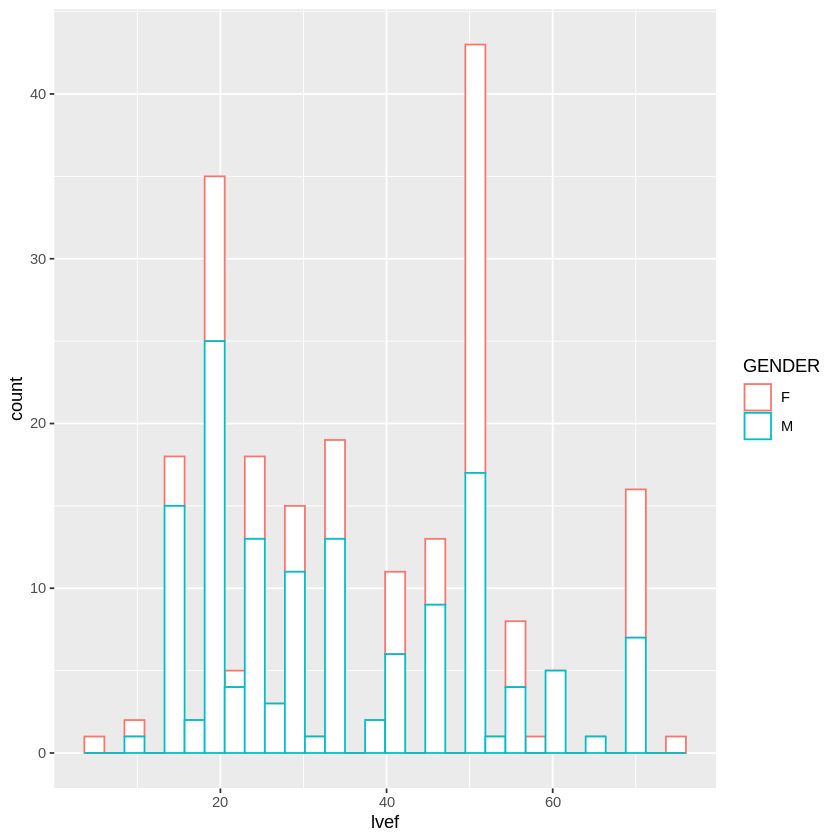

In [24]:
ggplot(cohort_clean, aes(x=lvef, color=GENDER)) + geom_histogram(fill="white")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



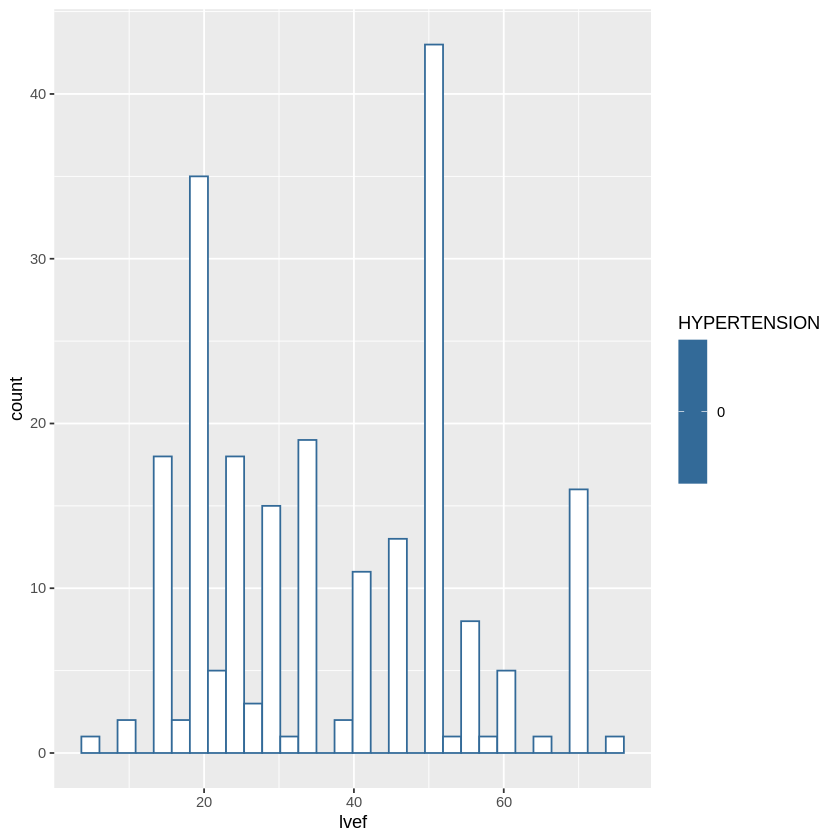

In [25]:
ggplot(cohort_clean, aes(x=lvef, color=HYPERTENSION)) + geom_histogram(fill="white")

#### Questions:



Do you observe any appreciable difference? Does these distributions show a remarkable characteristic?

